In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = yf.download('TSLA').reset_index()
df = df[(df['Date'] >= "2012-01-01") & (df['Date'] <= "2023-05-12")].reset_index(drop=True)

[*********************100%%**********************]  1 of 1 completed


In [3]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2854,2023-05-08,173.720001,173.800003,169.190002,171.789993,171.789993,112249400
2855,2023-05-09,168.949997,169.820007,166.559998,169.149994,169.149994,88965000
2856,2023-05-10,172.550003,174.429993,166.679993,168.539993,168.539993,119840700
2857,2023-05-11,168.699997,173.570007,166.789993,172.080002,172.080002,103889900
2858,2023-05-12,176.070007,177.380005,167.229996,167.979996,167.979996,157577100


In [4]:
# split data into train and training set
train_data = df[df['Date'] < '2022-01-01']
test_data = df[df['Date'] >= '2022-01-01']

In [5]:
# scaling the closing price
scaler = MinMaxScaler(feature_range=(0,1))
train_data['scaled_values'] = scaler.fit_transform(train_data['Close'].values.reshape(-1,1))
#df['scaled_values']=np.reshape(df['Close'],(-1,1))


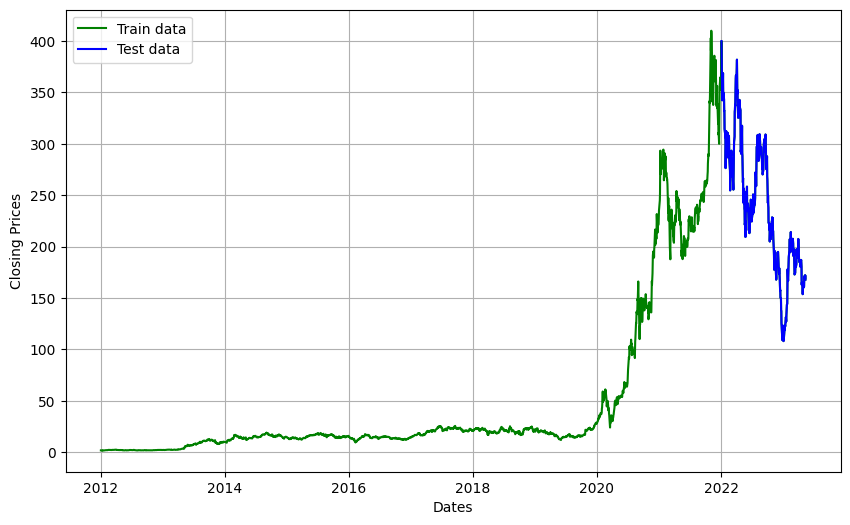

In [6]:


# plotting the data
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df['Date'], df['Close'], 'green', label='Train data')
plt.plot(test_data['Date'], test_data['Close'], 'blue', label='Test data')
plt.legend()

In [7]:
x_train = []
y_train = []

for i in range(60, len(train_data['scaled_values'])):
    x_train.append(train_data['scaled_values'][i-60:i])
    y_train.append(train_data['scaled_values'][i])

x_train, y_train = np.array(x_train), np.array(y_train)

# converting it back to 3D array as required by LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [8]:
x_test = []
y_test = test_data['Close']

for i in range(60, len(test_data)):
    x_test.append(test_data['Close'][i-60:i])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [9]:
!pip install keras

In [10]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

2024-06-05 11:06:42.096781: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-05 11:06:42.104340: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-05 11:06:42.160521: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-05 11:06:43.714552: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [11]:
# define model architecture

# Initialize model
model = Sequential()

# LSTM layer 1
model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.25))

# LSTM layer 2
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.25))

# LSTM layer 3
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.25))

# LSTM layer 4
model.add(LSTM(units = 50))
model.add(Dropout(0.25))

# final layer
model.add(Dense(units = 1))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(optimizer = 'adam', loss = 'mean_absolute_error')

In [13]:
model.fit(x_train, y_train, epochs = 10, batch_size = 32)

Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 15s 114ms/step - loss: 0.0460
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - loss: 0.0233
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - loss: 0.0172
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - loss: 0.0162
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - loss: 0.0167
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - loss: 0.0130
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - loss: 0.0144
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - loss: 0.0138
Epoch 9/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - loss: 0.0191
Epoch 10/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - loss: 0.0145


In [14]:
# predict on test data
predicted_stock_price = model.predict(x_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step


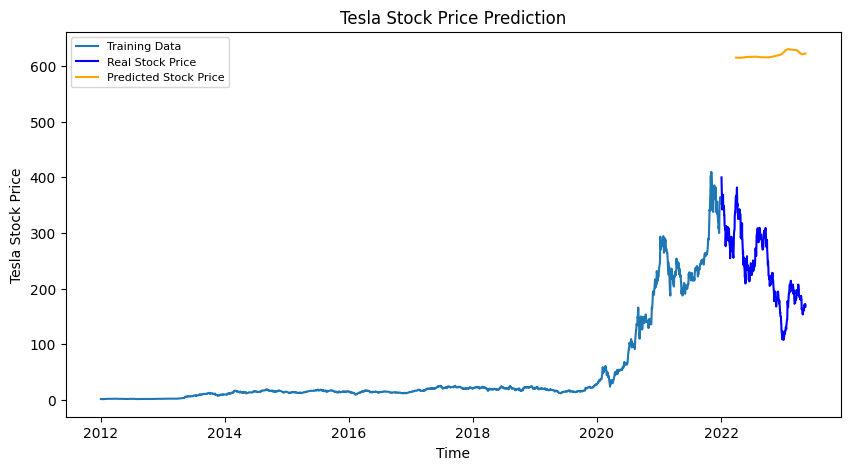

In [15]:
# plot all the series together
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data['Date'], train_data['Close'], label='Training Data')
plt.plot(test_data['Date'], test_data['Close'], color = 'blue', label='Real Stock Price')
plt.plot(test_data[60:]['Date'], predicted_stock_price, color = 'orange',label='Predicted Stock Price')

plt.title('Tesla Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Tesla Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [16]:
from sklearn.metrics import mean_absolute_error
import math

y_true = test_data[60:]['Close'].values
y_pred = predicted_stock_price

# report performance
mse = mean_squared_error(y_true, y_pred)
print('MSE: '+str(mse))
mae = mean_absolute_error(y_true, y_pred)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(y_true, y_pred))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))
print('MAPE: '+str(mape))

MSE: 160294.38221915808
MAE: 395.34569143741686
RMSE: 400.3678086699255
MAPE: 1.9763607328699133


#SECOND MODEL

In [116]:
# here we are importing important libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("fivethirtyeight")
sns.set_style('whitegrid')
%matplotlib inline
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM

In [117]:
# here we are Getting the stock quote

df = yf.download('TSLA').reset_index()
df = df[(df['Date'] >= "2020-01-01") & (df['Date'] <= "2023-05-12")].reset_index(drop=True)

[*********************100%%**********************]  1 of 1 completed


In [118]:
df.shape

(847, 7)

In [119]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,28.299999,28.713333,28.114000,28.684000,28.684000,142981500
1,2020-01-03,29.366667,30.266666,29.128000,29.534000,29.534000,266677500
2,2020-01-06,29.364668,30.104000,29.333332,30.102667,30.102667,151995000
3,2020-01-07,30.760000,31.441999,30.224001,31.270666,31.270666,268231500
4,2020-01-08,31.580000,33.232666,31.215334,32.809334,32.809334,467164500


In [120]:
#Creating a new dataframe with only the 'Close' column
data = df.filter(['Close'])
#Converting the dataframe to a numpy array
dataset = data.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8)
train_data = dataset[0:training_data_len  , : ]

In [121]:
# here we are Scaling the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(train_data)
scaled_data.shape

(678, 1)

In [122]:
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

[array([28.68400002, 29.5340004 , 30.10266685, 31.27066612, 32.8093338 ,
       32.08933258, 31.87666702, 34.99066544, 35.86133194, 34.56666565,
       34.23266602, 34.03333282, 36.47999954, 37.97066879, 38.14666748,
       37.6546669 , 37.20133209, 37.79333115, 38.73266602, 42.72066879,
       43.37133408, 52.        , 59.13733292, 48.97999954, 49.93066788,
       49.87133408, 51.41866684, 51.62533188, 51.152668  , 53.59999847,
       53.33533478, 57.2266655 , 61.16133118, 59.96066666, 60.06666565,
       55.58599854, 53.32733154, 51.91999817, 45.26666641, 44.53266525,
       49.57466888, 49.70066833, 49.96666718, 48.30266571, 46.89866638,
       40.53333282, 43.02199936, 42.2820015 , 37.36999893, 36.44133377,
       29.67133331, 28.68000031, 24.08133316, 28.50933266, 28.50200081,
       28.95266724, 33.66666794, 35.95000076, 35.21066666, 34.29066849])]
[33.47533416748047]

[array([28.68400002, 29.5340004 , 30.10266685, 31.27066612, 32.8093338 ,
       32.08933258, 31.87666702, 34.990

In [123]:
#Here we are Converting x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [124]:
# Here we are reshaping the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [125]:
#now we are Building the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [126]:
# here we are Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [128]:
# here we are training the model
model.fit(x_train, y_train, batch_size=1, epochs=10)

Epoch 1/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - loss: 1664.2180
Epoch 2/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 551.7607
Epoch 3/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - loss: 379.0242
Epoch 4/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - loss: 392.1969
Epoch 5/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 328.3279
Epoch 6/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 222.8114
Epoch 7/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 211.8112
Epoch 8/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 209.6239
Epoch 9/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - loss: 188.6923
Epoch 10/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - loss: 216.1432


In [129]:
# here we are testing data set
test_data = dataset[training_data_len - 60: , : ]
#Creating the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [130]:
# here we are converting x_test to a numpy array  
x_test = np.array(x_test)

In [131]:
# here we are reshaping the data into the shape accepted by the LSTM  
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [135]:
# now we are getting the models predicted price values
predictions = model.predict(x_test) 
#predictions = scaler.inverse_transform(predictions)#Undo scaling

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [136]:
# here we are calculaing the value of RMSE 
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

12.867280812598654

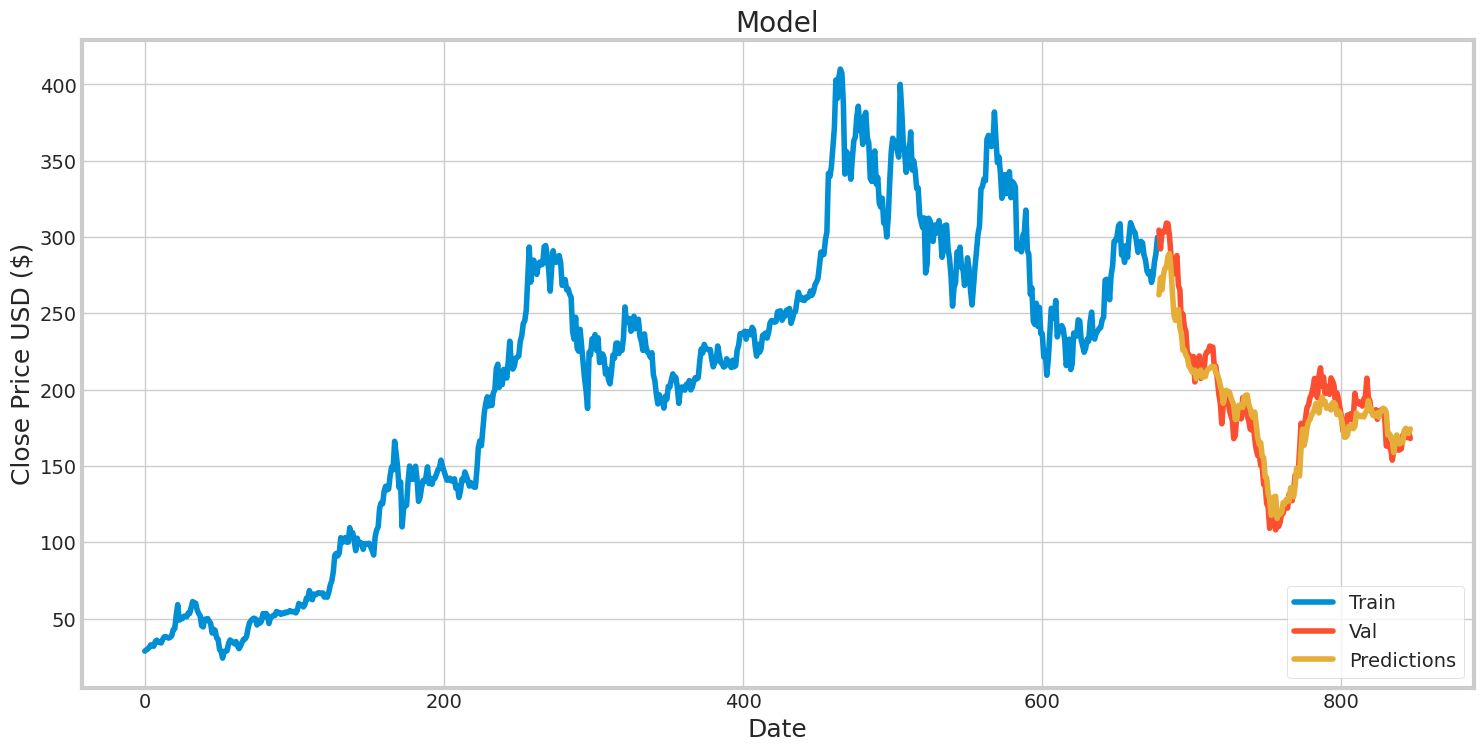

In [137]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [144]:
data[training_data_len:].shift(1)

,Close
679,NaN
680,292.130005
681,302.609985
682,303.750000
683,303.350006
...,...
842,170.059998
843,171.789993
844,169.149994
845,168.539993


In [141]:
predictions


array([[262.08063 ],
       [273.17798 ],
       [265.21518 ],
       [275.12234 ],
       [279.5099  ],
       [280.3082  ],
       [287.38916 ],
       [289.05597 ],
       [279.53162 ],
       [263.4681  ],
       [248.68471 ],
       [245.3796  ],
       [248.29327 ],
       [252.43037 ],
       [240.47635 ],
       [236.56413 ],
       [225.72575 ],
       [225.9625  ],
       [222.552   ],
       [220.86734 ],
       [215.32559 ],
       [214.09178 ],
       [211.57022 ],
       [211.28537 ],
       [212.69513 ],
       [207.16829 ],
       [211.1309  ],
       [212.03468 ],
       [212.77388 ],
       [207.85382 ],
       [209.39368 ],
       [208.50731 ],
       [212.12047 ],
       [213.44028 ],
       [213.82683 ],
       [215.0504  ],
       [214.9723  ],
       [215.07442 ],
       [210.80663 ],
       [210.05096 ],
       [207.10295 ],
       [202.50606 ],
       [199.01826 ],
       [190.9796  ],
       [196.5981  ],
       [199.56522 ],
       [197.4965  ],
       [198.5